In [80]:
import pandas as pd
from typing import List
from pre_processing import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import lightgbm as lgb
pd.set_option("display.max_columns", None)

## Data processing
Load data in a single dataframe and split into train and test

In [57]:
PATH = './Train/Train'

df = load_general(PATH)

df_train, df_test = train_test_split(df)

has_nan(df_train)

(True,
 station                           0
 latitude                          0
 longitude                         0
 numDocks                          0
 timestamp                         0
 year                              0
 month                             0
 day                               0
 hour                              0
 weekday                           0
 weekhour                          0
 isHoliday                         0
 windMaxSpeed.m.s                 52
 windMeanSpeed.m.s                52
 windDirection.grades            276
 temperature.C                    52
 relHumidity.HR                   52
 airPressure.mb                   52
 precipitation.l.m2               52
 bikes_3h_ago                    237
 full_profile_3h_diff_bikes     9647
 full_profile_bikes             9476
 short_profile_3h_diff_bikes    9647
 short_profile_bikes            9476
 bikes                            52
 dtype: int64)

Perform data processing and basic feature selection

In [58]:
#drop instance where there's no number of bikes
df_train = drop_nan_bikes(df_train)
df_test = drop_nan_bikes(df_test)

# replaces days with numbers
# df_train = day_transform(df_train)
# df_test = day_transform(df_test)
df_train = pd.get_dummies(df_train,columns=['weekday'])
df_test = pd.get_dummies(df_test,columns=['weekday'])

#replaces NaN using KNN imputer
df_train = nan_impute(df_train)
df_test = nan_impute(df_test)

# #removes features with zero variance
df_train = var_transform(df_train)
df_test = var_transform(df_test)

# #has_nan(df_test)
#
df_test

,station,latitude,longitude,numDocks,timestamp,day,hour,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,263.0,39.494718,-0.386875,15.0,1.414242e+09,25.0,15.0,136.0,0.0,9.7,3.2,315.0,29.2,23.0,1019.5,2.0,-3.0,4.333333,-3.0,4.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,248.0,39.455440,-0.366517,23.0,1.414408e+09,27.0,12.0,13.0,0.0,4.8,0.0,180.0,22.8,69.0,1022.6,1.0,1.0,5.000000,1.0,5.000000,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,218.0,39.459370,-0.370340,20.0,1.414778e+09,31.0,19.0,116.0,0.0,9.7,4.8,22.5,20.2,80.0,1023.5,3.0,4.5,14.250000,4.5,14.250000,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,225.0,39.458828,-0.336889,14.0,1.413666e+09,18.0,23.0,144.0,0.0,1.6,0.0,67.5,20.9,85.0,1022.7,9.0,3.0,10.000000,3.0,10.000000,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,232.0,39.475213,-0.336315,15.0,1.412658e+09,7.0,7.0,32.0,0.0,9.7,1.6,225.0,20.1,58.0,1010.3,5.0,1.8,3.400000,1.8,3.400000,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13941,239.0,39.462902,-0.361886,20.0,1.413205e+09,13.0,15.0,16.0,0.0,30.6,14.5,180.0,23.7,46.0,1009.3,8.0,1.0,6.000000,1.0,6.000000,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13942,273.0,39.494136,-0.406020,16.0,1.413850e+09,21.0,2.0,27.0,0.0,3.2,0.0,202.5,18.5,81.0,1021.5,8.0,-1.0,7.500000,-1.0,7.500000,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13943,256.0,39.458694,-0.397848,15.0,1.413054e+09,11.0,21.0,142.0,0.0,14.5,6.4,45.0,22.1,78.0,1009.7,8.0,0.0,12.000000,0.0,12.000000,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13944,223.0,39.467747,-0.358505,20.0,1.413169e+09,13.0,5.0,6.0,0.0,14.5,4.8,202.5,17.9,61.0,1010.5,2.0,1.0,1.000000,1.0,1.000000,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Find which feature has highest correlation with bikes

In [59]:
corr_matrix = correl(df_train)
print(corr_matrix['bikes'].sort_values(ascending=False).head(10))

bikes                          1.000000
bikes_3h_ago                   0.671451
short_profile_bikes            0.649997
full_profile_bikes             0.649997
longitude                      0.278771
short_profile_3h_diff_bikes    0.263314
full_profile_3h_diff_bikes     0.263314
latitude                       0.195154
numDocks                       0.118270
hour                           0.027827
Name: bikes, dtype: float64


<AxesSubplot:xlabel='short_profile_3h_diff_bikes', ylabel='bikes'>

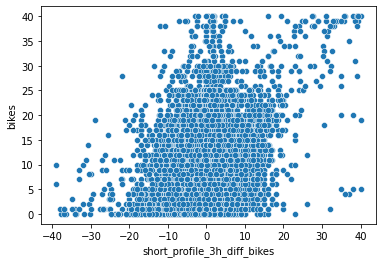

In [60]:
sns.scatterplot(data=df_train, x='short_profile_3h_diff_bikes', y='bikes')

Find inter-feature correlation and drop features with a correlation higher than 0.95

Obviously windmean and windmax are positively correlated.

['day', 'windMeanSpeed.m.s', 'short_profile_3h_diff_bikes', 'short_profile_bikes']


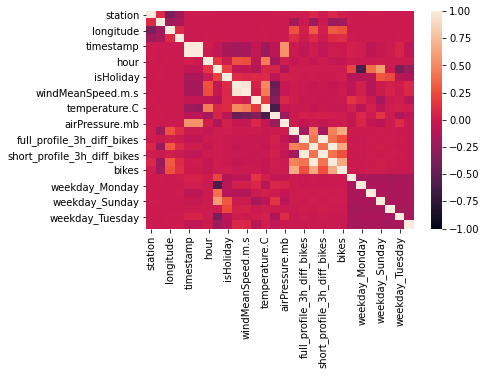

In [61]:
sns.heatmap(df_train.corr(), vmin=-1.0, vmax=1.0)

dropped = high_correl(df_train, 0.95)
dropped = high_correl(df_test, 0.95)
print(dropped)

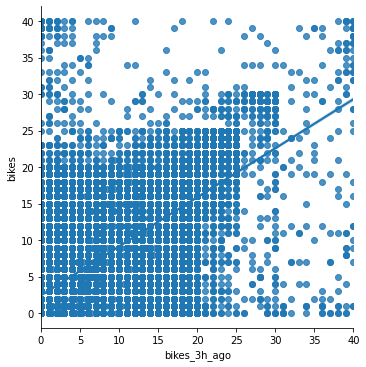

In [62]:
sns.lmplot(data= df_train, x='bikes_3h_ago', y='bikes')

Plot histograms to see whether input is Gaussian

array([[<AxesSubplot:title={'center':'station'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'numDocks'}>,
        <AxesSubplot:title={'center':'timestamp'}>],
       [<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'weekhour'}>,
        <AxesSubplot:title={'center':'isHoliday'}>,
        <AxesSubplot:title={'center':'windMaxSpeed.m.s'}>,
        <AxesSubplot:title={'center':'windDirection.grades'}>],
       [<AxesSubplot:title={'center':'temperature.C'}>,
        <AxesSubplot:title={'center':'relHumidity.HR'}>,
        <AxesSubplot:title={'center':'airPressure.mb'}>,
        <AxesSubplot:title={'center':'bikes_3h_ago'}>,
        <AxesSubplot:title={'center':'full_profile_3h_diff_bikes'}>],
       [<AxesSubplot:title={'center':'full_profile_bikes'}>,
        <AxesSubplot:title={'center':'bikes'}>,
        <AxesSubplot:title={'center':'weekday_Friday'}>,
        <

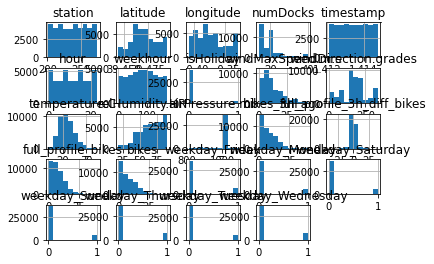

In [63]:
df_train.hist()

<AxesSubplot:>

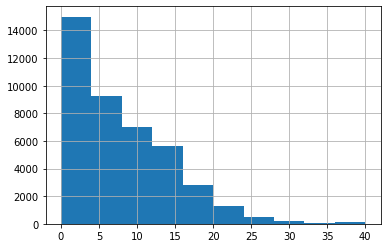

In [64]:
df_train['bikes'].hist()

Let's now investigate some categorical features

In [65]:
# #sns.set_style('darkgrid')
# #f, axes = plt.subplots(2,2, figsize = (15,15))
# sns.boxplot(data = df_train, x = 'weekday', y = 'bikes', palette="Set3")

<AxesSubplot:xlabel='isHoliday', ylabel='bikes'>

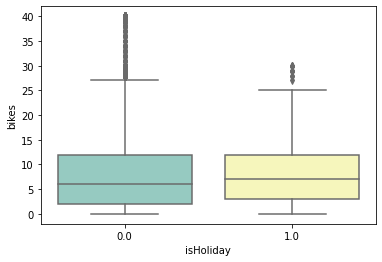

In [66]:
sns.boxplot(data = df_train, x = 'isHoliday', y = 'bikes', palette="Set3")

<AxesSubplot:xlabel='hour', ylabel='bikes'>

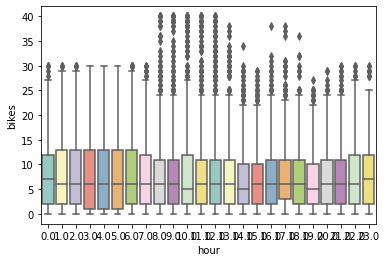

In [67]:
sns.boxplot(data = df_train, x = 'hour', y = 'bikes', palette="Set3")

## Model selection

Scale the features and impute missing data

In [68]:
#store features and target in two different dataframes
X_train = df_train.loc[:, df_train.columns != 'bikes']
Y_train = df_train['bikes']

In [69]:
X_train

,station,latitude,longitude,numDocks,timestamp,hour,weekhour,isHoliday,windMaxSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,217.0,39.463717,-0.367085,20.0,1.412114e+09,0.0,49.0,0.0,11.3,67.5,21.3,85.0,855.3,2.8,0.800000,2.600000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,203.0,39.476715,-0.375433,25.0,1.413432e+09,6.0,79.0,0.0,22.5,202.5,21.2,68.0,1012.4,0.0,1.000000,1.500000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,259.0,39.465639,-0.396839,15.0,1.414271e+09,23.0,144.0,0.0,0.0,146.3,20.4,67.0,1021.8,2.0,0.000000,2.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,226.0,39.461920,-0.338812,25.0,1.412359e+09,20.0,117.0,0.0,9.7,337.5,22.8,77.0,1002.7,23.0,0.600000,17.200000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,225.0,39.458828,-0.336889,14.0,1.413954e+09,7.0,56.0,0.0,35.4,135.0,22.4,43.0,1022.2,11.0,-0.666667,9.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41849,209.0,39.475002,-0.387938,16.0,1.413950e+09,6.0,55.0,0.0,11.3,157.5,22.7,49.0,1022.1,0.0,0.333333,4.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41850,220.0,39.458389,-0.344496,15.0,1.412744e+09,7.0,56.0,0.0,9.7,202.5,19.6,67.0,1011.1,0.0,-3.000000,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41851,261.0,39.470708,-0.397475,15.0,1.413209e+09,16.0,17.0,0.0,32.2,180.0,23.8,44.0,1009.0,1.0,5.000000,6.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
41852,257.0,39.461452,-0.400487,15.0,1.413832e+09,21.0,22.0,0.0,4.8,292.5,21.4,81.0,1021.2,5.0,0.000000,12.500000,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [70]:
#scaled test set
# scaled_X_test = scaled_df_test.loc[:, df_test.columns != 'bikes']
# scaled_Y_test= scaled_df_test['bikes']

#unscaled test set (to see predictions)
X_test = df_test.loc[:, df_test.columns != 'bikes']
Y_test= df_test['bikes']

In [71]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'scaler.joblib')

# imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance')
# X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


['scaler.joblib']

Experiment with baseline methods

In [44]:
# pipelines = [('Linear regression', Pipeline([('Scaler', MinMaxScaler()), ("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('LR',LinearRegression())])),
#              ('Ridge', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('L2',Ridge())])),
#              ('DecisionTree',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('DT',DecisionTreeRegressor())])),
#              ('RandomForest',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('RF',RandomForestRegressor())])),
#              ('KNN',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('KNN',KNeighborsRegressor())])),
#            #  ('SVR',Pipeline([('Scaler', RobustScaler()),('SVR',SVR())])),
#              ('GradientBoosting', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('GBM', GradientBoostingRegressor())]))]

pipelines = [('LR',LinearRegression()),
             ('L2',Ridge()),
             ('DT',DecisionTreeRegressor()),
             ('RF',RandomForestRegressor()),
             ('LGB',lgb.LGBMRegressor() ),
             ('KNN',KNeighborsRegressor()),
             ('SVR',SVR()),
             ('GBM', GradientBoostingRegressor())]

#shuffle the data to preserve generality (avoids overfitting)
#df[i] = shuffle(df[i])

for model, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f'Model {model} : {cv_scores.mean()}\n')

print("\n")

Model LR : -2.8435135928985233

Model L2 : -2.8435661943558928

Model DT : -2.9314388381883245

Model RF : -2.191804725381104

Model LGB : -2.318909012689745

Model KNN : -2.7045831648430023



KeyboardInterrupt: 

As it is possible to see RandomForest and SVR are the ones that perform better. Let's try to tune Random Forest first

In [26]:
param_grid_forest = {'n_estimators': np.arange(100, 2000, 500),
          'max_features': ['auto', 'sqrt'],
          'max_depth': list(np.arange(5, 100, 15)) + [None],
          'min_samples_split': list(np.linspace(0.1, 1.0, 10, endpoint=True)) + [5, 10, 20],
          'min_samples_leaf': list(np.linspace(0.1, 0.5, 5, endpoint=True))+ [5, 10]
          # 'min_samples_split': [2, 5, 10],
          # 'min_samples_leaf': [1, 2, 4]
         }

tree_reg = RandomizedSearchCV(estimator = RandomForestRegressor(),
                              param_distributions = param_grid_forest, n_iter = 100,
                              verbose = 2, n_jobs = 3, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
tree_reg.fit(X_train, Y_train)
joblib.dump(tree_reg.best_estimator_, "randomforest.joblib")
print(f'Best parameters for dataset are {tree_reg.best_params_}')
print(f'Best score is {tree_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for dataset are {'n_estimators': 1100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 65}
Best score is -2.238707706823697


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 32.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 45.7min finished


In [31]:
forest = joblib.load("randomforest.joblib")
predictions = forest.predict(X_test)
#predictions = tree_reg.best_estimator_.predict(X_test)
# test_error = mean_absolute_error(predictions, Y_test)
# print(f"The MAE on the test set is {test_error}\n")
#
#
sorted(dict(zip(X_train.columns, tree_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

[('bikes_3h_ago', 0.4824085777471648),
 ('full_profile_bikes', 0.18560873919103857),
 ('full_profile_3h_diff_bikes', 0.089327227707649),
 ('numDocks', 0.0398456682463559),
 ('timestamp', 0.03566229650041093),
 ('hour', 0.024604588479433503),
 ('station', 0.02332953083194621),
 ('longitude', 0.019024024027411685),
 ('weekhour', 0.018686093603316658),
 ('latitude', 0.01703346300976159),
 ('airPressure.mb', 0.01423227933974061),
 ('temperature.C', 0.012638130551370065),
 ('relHumidity.HR', 0.010916864415192337),
 ('windMaxSpeed.m.s', 0.00883515547903637),
 ('windDirection.grades', 0.006677364611354605),
 ('isHoliday', 0.006609018889176927),
 ('weekday_Thursday', 0.0012455934209939649),
 ('weekday_Friday', 0.0008658351228526676),
 ('weekday_Saturday', 0.0007646941929058207),
 ('weekday_Wednesday', 0.0006984261290457752),
 ('weekday_Tuesday', 0.0006212000299218215),
 ('weekday_Sunday', 0.0001879362215420555),
 ('weekday_Monday', 0.0001772922523781537)]

In [32]:
prediction = pd.DataFrame(predictions, columns=['bikes'], dtype='int32')
mean_absolute_error(prediction, Y_test)

2.679093776885575

In [29]:
prediction

,bikes
0,3
1,9
2,6
3,9
4,1
...,...
13943,2
13944,4
13945,3
13946,6


In [30]:
Y_test

0        18.0
1        22.0
2         7.0
3         8.0
4         2.0
         ... 
13943     0.0
13944     9.0
13945     0.0
13946     0.0
13947     6.0
Name: bikes, Length: 13948, dtype: float64

Try with Optuna optimiser

In [40]:
def objective(trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 2000)
    rf_max_depth = trial.suggest_int("rf_max_depth", 5, 100)
    rf_min_samples_split = trial.suggest_uniform("rf_min_samples_split", 0.1, 10),
    rf_min_samples_leaf = trial.suggest_uniform("rf_min_samples_leaf", 0.1, 5),

    classifier_obj = RandomForestRegressor(
        max_depth=rf_max_depth, n_estimators=rf_n_estimators, min_samples_leaf=rf_min_samples_leaf,
        min_samples_split=rf_min_samples_split)

    score = cross_val_score(classifier_obj, X_train, Y_train, n_jobs=3, cv=5,scoring='neg_mean_absolute_error')
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2020-12-29 18:54:29,837] A new study created in memory with name: no-name-6ed0085b-1b39-4928-9a63-ef1a8d257974
[W 2020-12-29 18:54:30,785] Trial 0 failed, because the objective function returned nan.
[W 2020-12-29 18:54:31,149] Trial 1 failed, because the objective function returned nan.
[W 2020-12-29 18:54:31,941] Trial 2 failed, because the objective function returned nan.
[W 2020-12-29 18:54:33,043] Trial 3 failed, because the objective function returned nan.
[W 2020-12-29 18:54:34,375] Trial 4 failed, because the objective function returned nan.
[W 2020-12-29 18:54:35,107] Trial 5 failed, because the objective function returned nan.
[W 2020-12-29 18:54:35,690] Trial 6 failed, because the objective function returned nan.
[W 2020-12-29 18:54:36,535] Trial 7 failed, because the objective function returned nan.
[W 2020-12-29 18:54:36,812] Trial 8 failed, because the objective function returned nan.
[W 2020-12-29 18:54:37,564] Trial 9 failed, because the objective function returned n

KeyboardInterrupt: 

Now tune LGB

Now tune Support Vector Machine Regressor


In [82]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50),
             'min_child_samples': sp_randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8),
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
model = lgb.LGBMRegressor(n_jobs=3)

lgb_reg = RandomizedSearchCV(estimator = model,
                              param_distributions = param_test, n_iter = 100,
                              verbose = 2, cv=10, scoring='neg_mean_absolute_error')
print(f"Starting training...")
lgb_reg.fit(X_train, Y_train)
joblib.dump(lgb_reg.best_estimator_, "lgb.joblib")
print(f'Best parameters for dataset are {lgb_reg.best_params_}')
print(f'Best score is {lgb_reg.best_score_}')

Starting training...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] colsample_bytree=0.8862811277757232, min_child_samples=296, min_child_weight=0.01, num_leaves=32, reg_alpha=0, reg_lambda=10, subsample=0.47561339350759707 
[CV]  colsample_bytree=0.8862811277757232, min_child_samples=296, min_child_weight=0.01, num_leaves=32, reg_alpha=0, reg_lambda=10, subsample=0.47561339350759707, total=   0.3s
[CV] colsample_bytree=0.8862811277757232, min_child_samples=296, min_child_weight=0.01, num_leaves=32, reg_alpha=0, reg_lambda=10, subsample=0.47561339350759707 
[CV]  colsample_bytree=0.8862811277757232, min_child_samples=296, min_child_weight=0.01, num_leaves=32, reg_alpha=0, reg_lambda=10, subsample=0.47561339350759707, total=   0.2s
[CV] colsample_bytree=0.8862811277757232, min_child_samples=296, min_child_weight=0.01, num_leaves=32, reg_alpha=0, reg_lambda=10, subsample=0.47561339350759707 
[CV]  colsample_bytree=0.8862811277757232, min_child_samples=296, min_chil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.5min finished


In [241]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.values.astype(np.float))
# Y_train = scaler.fit_transform(Y_train.values.astype(np.float).reshape(-1, 1))

param_grid_kernel = {#'kernel': ['poly', 'rbf', 'sigmoid'],
                     #'epsilon': np.arange(0.1, 1.0, 0.1),
                     'gamma': [0.01, 0.1, 0.5, 1],
                     'C': [0.1, 1, 10, 100]
                       }
#pipe = make_pipeline(StandardScaler(), SVR())
svr_reg = GridSearchCV(estimator=SVR(),
                        param_grid = param_grid_kernel, #n_iter = 10,
                        verbose = 3, n_jobs = -3, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
svr_reg.fit(X_train, Y_train)
joblib.dump(svr_reg.best_estimator_, "svr.joblib")
print(f'Best parameters for dataset are {svr_reg.best_params_}')
print(f'Best score is {svr_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:  6.6min


KeyboardInterrupt: 

In [29]:
X_train

array([[241.        ,  39.46984411,  -0.32964496, ...,   3.        ,
          1.5       ,  11.5       ],
       [233.        ,  39.47854813,  -0.342366  , ...,   4.        ,
          0.        ,   6.25      ],
       [237.        ,  39.48567015,  -0.37859211, ...,   0.        ,
         11.        ,  12.        ],
       ...,
       [208.        ,  39.46905609,  -0.3757281 , ...,  29.        ,
         -8.25      ,  18.75      ],
       [268.        ,  39.45947405,  -0.40283117, ...,  11.        ,
          0.        ,   1.        ],
       [205.        ,  39.47078409,  -0.38270112, ...,   5.        ,
          1.5       ,   1.5       ]])